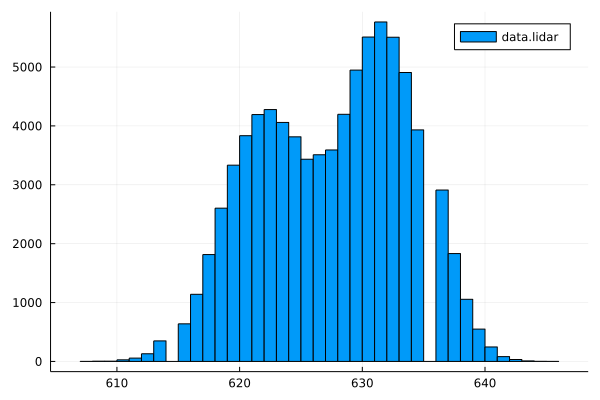

In [1]:
using DataFrames, CSV
using Plots
data = CSV.read("sensor_data_600.txt", DataFrame, header=["date", "time", "ir", "lidar"], delim=' ')
histogram(data.lidar, bin=maximum(data.lidar)-minimum(data.lidar), label="data.lidar")

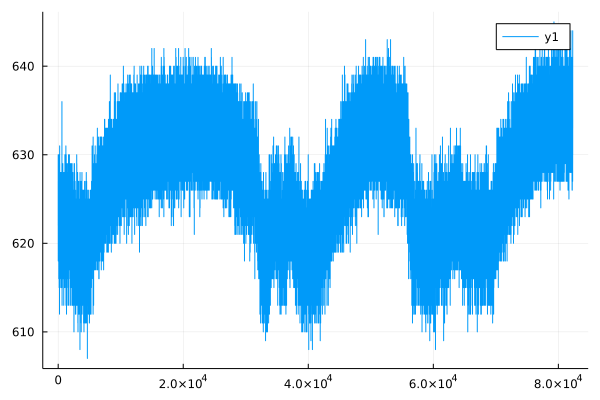

In [2]:
plot(data.lidar)

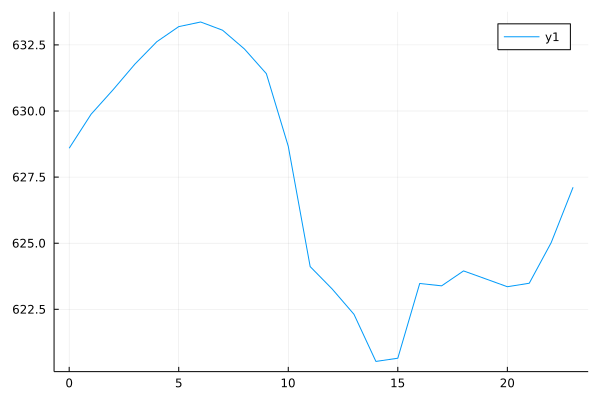

In [3]:
hour_array = [Int64(modf(e/10000)[2]) for e in data.time]
data.hour = hour_array # hour列を追加
gdf = groupby(data, :hour) # hourでグルーピングしたデータフレームを作成

using Statistics
d_mean = [mean(subdf.lidar) for (key, subdf) in pairs(gdf)] 
d_hour = [key.hour for (key, subdf) in pairs(gdf)] 

plot(d_hour, d_mean)

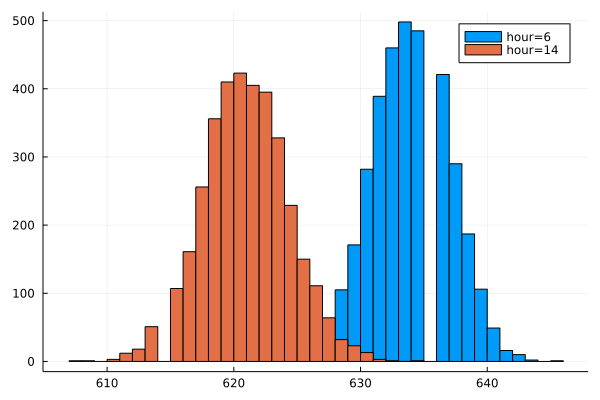

In [4]:
#d_6 = [subdf for (key, subdf) in pairs(gdf) if key.hour == 6][1]
#d_14 = [subdf for (key, subdf) in pairs(gdf) if key.hour == 14][1] 

d_6 = get(gdf, (hour=:6,), nothing) # こっちの方がシンプル
d_14 = get(gdf, (hour=:14,), nothing)

histogram(d_6.lidar, label="hour=6")
histogram!(d_14.lidar, label="hour=14")

In [5]:
# CountMapを使って時間毎にデータフレームを作成
using StatsBase
freq_cm = DataFrame()
for i in 0:length(gdf)-1
    d_i = get(gdf, (hour=:i,), nothing)
    if d_i != nothing
        count_map = countmap(d_i.lidar)
        freq_i = DataFrame(Dict(string(k)=>v  for (k,v) in pairs(count_map)))
    else
        freq_i = DataFrame()
    end 
    freq_cm = vcat(freq_cm, freq_i, cols=:union)
end
# 欠損値をゼロで埋める
for col in names(freq_cm)
    freq_cm[ismissing.(freq_cm[:,col]), col] .= 0.0
end

# FreqTableを使ったほうが簡単
using FreqTables
freq_table = freqtable(data, :lidar, :hour)

37×24 Named Matrix{Int64}
lidar ╲ hour │   0    1    2    3    4    5  …   18   19   20   21   22   23
─────────────┼──────────────────────────────────────────────────────────────
607          │   0    0    0    0    0    0  …    0    0    0    0    0    0
608          │   0    0    0    0    0    0       0    0    1    1    0    0
609          │   0    0    0    0    0    0       0    0    0    1    1    0
610          │   0    0    0    0    0    0       1    1   11    0    0    0
611          │   0    0    0    0    0    0       0    2    6   12    4    0
612          │   0    0    0    0    0    0       3    5   21   16    2    1
613          │   0    0    0    0    0    0       5   18   56   36    9    2
615          │   0    0    0    0    0    0      22   31   81   84   39    4
616          │   0    0    0    0    0    0      49   84  142  115   49    7
617          │   0    0    0    0    0    0      76  135  182  189   84   12
618          │   3    0    0    0    0    0     14

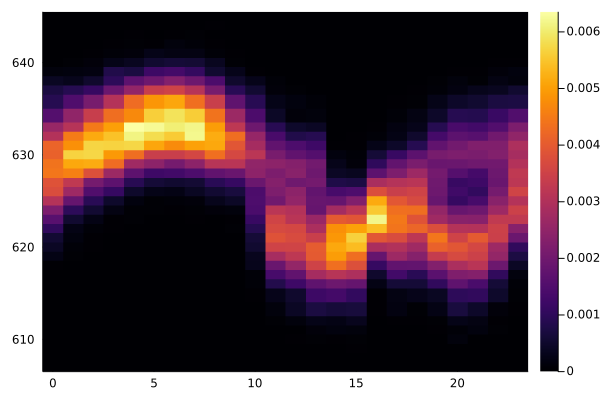

In [44]:
y_data = names(freq_table, 1)
x_data = names(freq_table, 2)
freqs = [val for val in freq_table]
probs = freqs / length(data.lidar)
heatmap(x_data, y_data, probs)

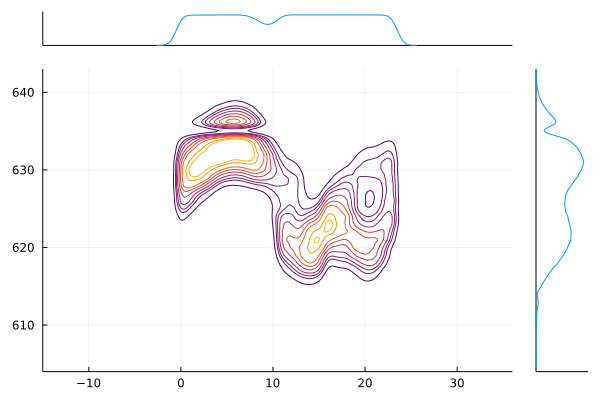

In [7]:
using StatsPlots
marginalkde(data.hour, data.lidar)

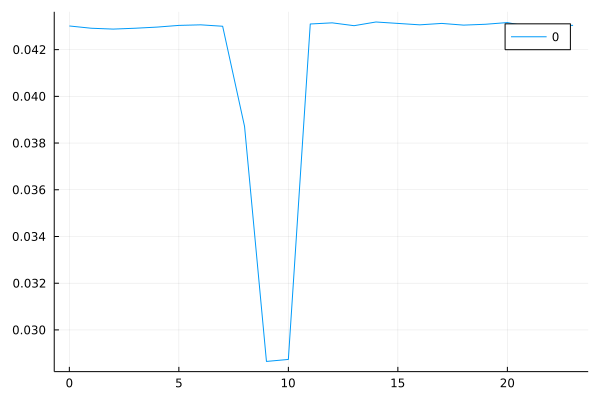

In [45]:
p_t = [sum(probs[:, m]) for m in 1:size(probs)[2]]
t = names(freq_table, 2)
plot(t, p_t, label="0")

In [46]:
sum(p_t)

0.9999999999999999

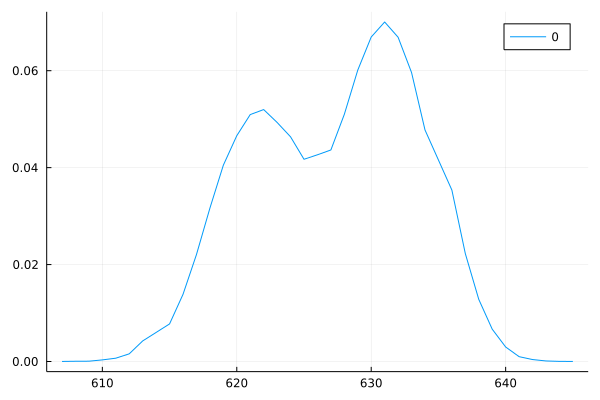

In [47]:
p_z = [sum(probs[m, :]) for m in 1:size(probs)[1]]
z = names(freq_table, 1)
plot(z, p_z, label="0")

In [48]:
sum(p_z)

1.0

In [49]:
cond_z_t = deepcopy(probs)
for i in 1:size(probs)[2]
    cond_z_t[:, i] = probs[:, i] / p_t[i]
end

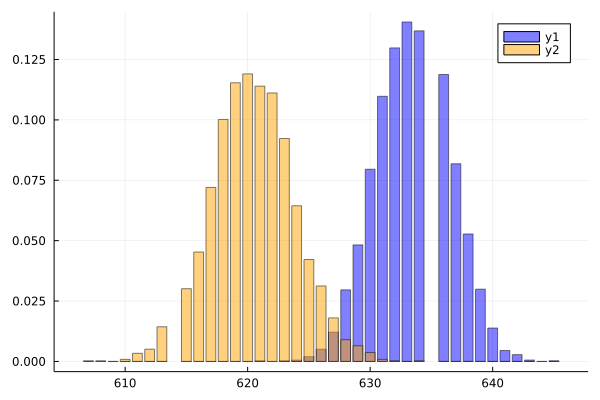

In [50]:
z = names(freq_table, 1)
bar(z, cond_z_t[:, 7], color="blue", alpha=0.5)
bar!(z, cond_z_t[:, 15], color="orange", alpha=0.5)

In [60]:
cond_t_z = deepcopy(probs)
for i in 1:size(probs)[1]
    cond_t_z[i, :] = probs[i, :] / p_z[i]
end

#dict_p_z = Dict(zip(z, p_z))
#dict_p_t = Dict(zip(t, p_t))

idx_t13 = findall( x -> x == 13, t)[1]
idx_z630 = findall( x -> x == 630, z)[1]
println("p(z=630)=", p_z[idx_z630])
println("p(t=13)=", p_t[idx_t13])
println("p(t=13|z=630)=", cond_t_z[idx_z630, idx_t13])
println("p(t=13|z=630)=", cond_t_z[idx_z630, idx_t13])
println("Bayes p(z=630|t=13)=", cond_t_z[idx_z630, idx_t13] * p_z[idx_z630] / p_t[idx_t13])
println("answer p(z=630|t=13)=", cond_z_t[idx_z630, idx_t13])

p(z=630)=0.06694936878045224
p(t=13)=0.043024993620976656
p(t=13|z=630)=0.023230490018148822
p(t=13|z=630)=0.023230490018148822
Bayes p(z=630|t=13)=0.036147980796385204
answer p(z=630|t=13)=0.036147980796385204


In [75]:
function bayes_estimation(sensor_value, current_estimation)
    new_estimation = []
    for i in 0:23
        idx_t = findall( x -> x == i, t)[1]
        idx_sensor_value = findall( x -> x == sensor_value, z)[1]
        push!(new_estimation, cond_z_t[idx_sensor_value, idx_t] * current_estimation[i+1])
    end
    return new_estimation / sum(new_estimation) # 正規化
end

bayes_estimation (generic function with 1 method)

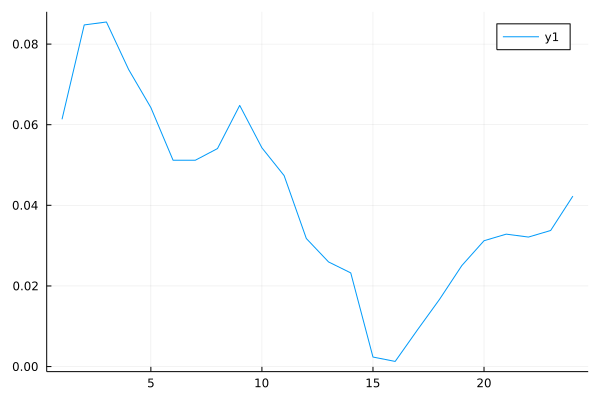

In [76]:
estimation = bayes_estimation(630, p_t)
plot(estimation)

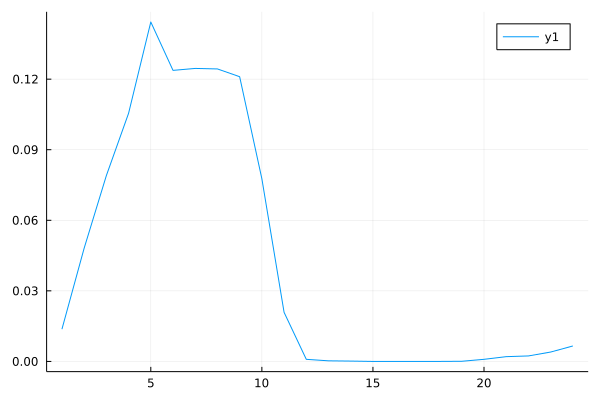

In [78]:
values_5 = [630, 632, 636] # 得られたセンサ値

estimation = deepcopy(p_t)
for v in values_5
    estimation = bayes_estimation(v, estimation)
end
plot(estimation)

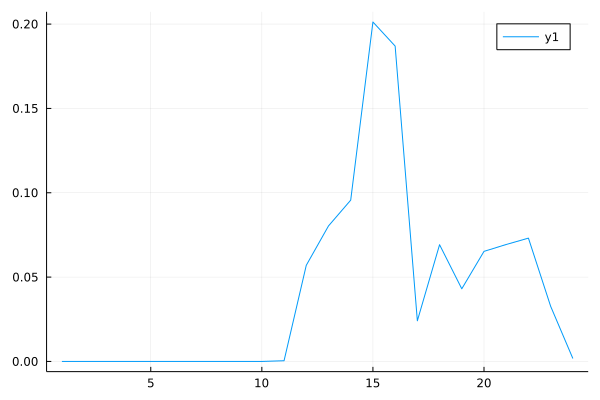

In [79]:
values_11 = [617, 624, 619] # sensor_data_600.txtから拾ってきた11時台のセンサ値

estimation = deepcopy(p_t)
for v in values_11
    estimation = bayes_estimation(v, estimation)
end
plot(estimation)